# MSA-TF2 Model Evaluation

This notebook evaluates the trained MSA-TF2 model on the test set with a focus on:
- **MAE (Mean Absolute Error)** metric
- **Scatter plot** showing predicted vs actual sentiment scores


## 1. Import Libraries and Setup


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# Disable GPU, force CPU execution
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.config.set_visible_devices([], 'GPU')

# Add current directory to path to import local modules
sys.path.insert(0, os.getcwd())

from utils.data_loader import make_dataset
from models import (
    MSASeqLevelModel,
    ModalityEncoder,
    CrossModalFusion,
    AdaptiveFusionHead,
    TransformerBlock,
    CrossAttentionBlock,
    LearnablePositionalEmbedding
)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Device: CPU only (GPU disabled)")
print("✓ All custom model classes imported successfully")


TensorFlow version: 2.16.2
Device: CPU only (GPU disabled)
✓ All custom model classes imported successfully


## 2. Load Trained Model

We'll load the best sequence-level model that was trained previously.


In [2]:
# Paths
weights_path = './weights/seqlevel_best_val_mae_20251019_010827.h5'
config_path = './weights/seqlevel_config_20251019_010827.json'

# Load configuration
print(f"Loading configuration from: {config_path}")
import json
with open(config_path, 'r') as f:
    config = json.load(f)

arch_config = config['architecture']
print("Architecture configuration:")
for key, value in arch_config.items():
    print(f"  {key}: {value}")

# Fixed input dimensions from CMU-MOSEI data
text_dim = 300
audio_dim = 74
video_dim = 713

# Recreate model architecture
print(f"\nRecreating model architecture...")
model = MSASeqLevelModel(
    seq_len=arch_config['seq_len'],
    text_dim=text_dim,
    audio_dim=audio_dim,
    video_dim=video_dim,
    model_dim=arch_config['model_dim'],
    num_heads=arch_config['num_heads'],
    ff_dim=arch_config['ff_dim'],
    n_layers_mod=arch_config['n_layers_mod'],
    n_layers_fuse=arch_config['n_layers_fuse'],
    bidirectional_fusion=arch_config['bidirectional_fusion'],
    pooling_method=arch_config['pooling_method'],
    dropout_rate=arch_config['dropout_rate']
)

# Build model with dummy input
dummy_t = tf.zeros((1, arch_config['seq_len'], text_dim))
dummy_a = tf.zeros((1, arch_config['seq_len'], audio_dim))
dummy_v = tf.zeros((1, arch_config['seq_len'], video_dim))
_ = model((dummy_t, dummy_a, dummy_v), training=False)

# Load weights
print(f"\nLoading weights from: {weights_path}")
model.load_weights(weights_path)
print("✓ Model and weights loaded successfully!")

# Compile model
model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])

# Display model summary
print("\nModel Summary:")
model.summary()


Loading configuration from: ./weights/seqlevel_config_20251019_010827.json
Architecture configuration:
  seq_len: 20
  model_dim: 128
  num_heads: 4
  ff_dim: 256
  n_layers_mod: 2
  n_layers_fuse: 1
  bidirectional_fusion: False
  pooling_method: mean
  dropout_rate: 0.1

Recreating model architecture...

Loading weights from: ./weights/seqlevel_best_val_mae_20251019_010827.h5
✓ Model and weights loaded successfully!

Model Summary:


Model: "msa_seq_level_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_encoder (ModalityEncoder)  │ ?                      │       306,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ audio_encoder (ModalityEncoder) │ ?                      │       277,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ video_encoder (ModalityEncoder) │ ?                      │       358,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cross_modal_fusion              │ ?                      │       264,960 │
│ (CrossModalFusion)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ adaptive_fusion                 │ ?                      │         8,451 │
│ (AdaptiveFusionHead)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ regression_head (Dense)         │ (1, 1)                 │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,215,620 (4.64 MB)

 Trainable params: 1,215,620 (4.64 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Load Test Data


In [3]:
# Load test dataset
data_dir = './data'
batch_size = 32

test_data = make_dataset(data_dir, split='test', batch_size=batch_size)
print(f"\n✓ Test data loaded successfully with batch size: {batch_size}")


Loading test data from ./data...
✓ test data validation passed:
  Samples: 4662
  Text shape: (4662, 20, 300)
  Audio shape: (4662, 20, 74)
  Video shape: (4662, 20, 713)
  Labels shape: (4662, 1)
  Label range: [-3.000, 3.000]

✓ Test data loaded successfully with batch size: 32


## 4. Evaluate Model - MAE Metric


In [4]:
# Evaluate on test set
print("Evaluating model on test set...")
print("="*60)

test_results = model.evaluate(test_data, verbose=1)

print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
for metric_name, value in zip(model.metrics_names, test_results):
    print(f"{metric_name.upper()}: {value:.4f}")
print("="*60)


Evaluating model on test set...
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.6602 - mae: 0.6602 - mse: 0.7654

TEST SET RESULTS
LOSS: 0.6501
COMPILE_METRICS: 0.6501


## 5. Generate Predictions for Visualization


In [5]:
# Get predictions and ground truth
print("Generating predictions...")

y_true = []
y_pred = []

for batch_data, batch_labels in test_data:
    predictions = model.predict(batch_data, verbose=0)
    y_pred.append(predictions)
    y_true.append(batch_labels.numpy())

# Concatenate all batches
y_true = np.concatenate(y_true, axis=0).flatten()
y_pred = np.concatenate(y_pred, axis=0).flatten()

print(f"✓ Generated {len(y_true)} predictions")
print(f"  Prediction range: [{y_pred.min():.3f}, {y_pred.max():.3f}]")
print(f"  Ground truth range: [{y_true.min():.3f}, {y_true.max():.3f}]")


Generating predictions...
✓ Generated 4662 predictions
  Prediction range: [-2.914, 2.374]
  Ground truth range: [-3.000, 3.000]


2025-10-24 11:02:28.628569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 6. Calculate MAE Manually


In [6]:
# Calculate MAE manually to verify
mae = np.mean(np.abs(y_true - y_pred))

print("="*60)
print("MANUAL MAE CALCULATION")
print("="*60)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print("="*60)


MANUAL MAE CALCULATION
Mean Absolute Error (MAE): 0.6501


## 7. Create Scatter Plot (Predicted vs Actual)


✓ Scatter plot saved as 'evaluation_scatter_plot.png'


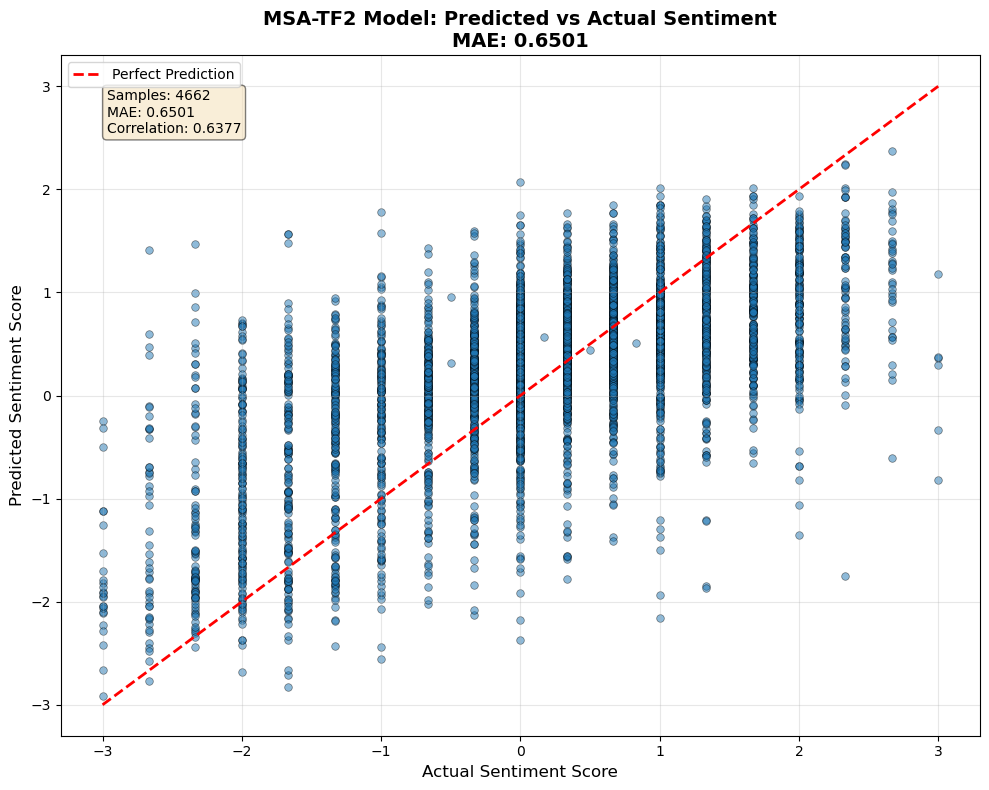

In [7]:
# Create scatter plot
plt.figure(figsize=(10, 8))

# Plot predictions vs actual
plt.scatter(y_true, y_pred, alpha=0.5, s=30, edgecolors='k', linewidth=0.5)

# Add perfect prediction line (diagonal)
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

# Labels and title
plt.xlabel('Actual Sentiment Score', fontsize=12)
plt.ylabel('Predicted Sentiment Score', fontsize=12)
plt.title(f'MSA-TF2 Model: Predicted vs Actual Sentiment\nMAE: {mae:.4f}', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add statistics box
textstr = f'Samples: {len(y_true)}\nMAE: {mae:.4f}\nCorrelation: {np.corrcoef(y_true, y_pred)[0, 1]:.4f}'
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('evaluation_scatter_plot.png', dpi=300, bbox_inches='tight')
print("✓ Scatter plot saved as 'evaluation_scatter_plot.png'")
plt.show()


## 8. Visualize Training Progress

Load and visualize the training log to understand how the model learned over time.


In [8]:
import pandas as pd

# Load training log
training_log_path = './weights/seqlevel_training_log_20251019_010827.csv'
print(f"Loading training log: {training_log_path}")

df = pd.read_csv(training_log_path)
print(f"✓ Loaded {len(df)} epochs of training data")
print(f"\nColumns: {', '.join(df.columns.tolist())}")
print(f"\nTraining summary:")
print(f"  Epochs trained: {len(df)}")
print(f"  Best validation MAE: {df['val_mae'].min():.4f} at epoch {df.loc[df['val_mae'].idxmin(), 'epoch']}")
print(f"  Final validation MAE: {df['val_mae'].iloc[-1]:.4f}")

# Display first few rows
print("\nFirst 5 epochs:")
df.head()


Loading training log: ./weights/seqlevel_training_log_20251019_010827.csv
✓ Loaded 21 epochs of training data

Columns: epoch, learning_rate, loss, mae, mse, val_loss, val_mae, val_mse

Training summary:
  Epochs trained: 21
  Best validation MAE: 0.6408 at epoch 5
  Final validation MAE: 0.6720

First 5 epochs:


,epoch,learning_rate,loss,mae,mse,val_loss,val_mae,val_mse
0,0,0.0001,0.783513,0.783513,1.054758,0.706449,0.706449,0.870165
1,1,0.0001,0.721007,0.721007,0.892818,0.650605,0.650605,0.748135
2,2,0.0001,0.682679,0.682679,0.811347,0.644561,0.644561,0.731501
3,3,0.0001,0.663419,0.663419,0.774956,0.644846,0.644846,0.730865
4,4,0.0001,0.644671,0.644671,0.739493,0.708574,0.708574,0.915235


### 8.1 Training Metrics Visualization


✓ Plotted MAE and MSE metrics


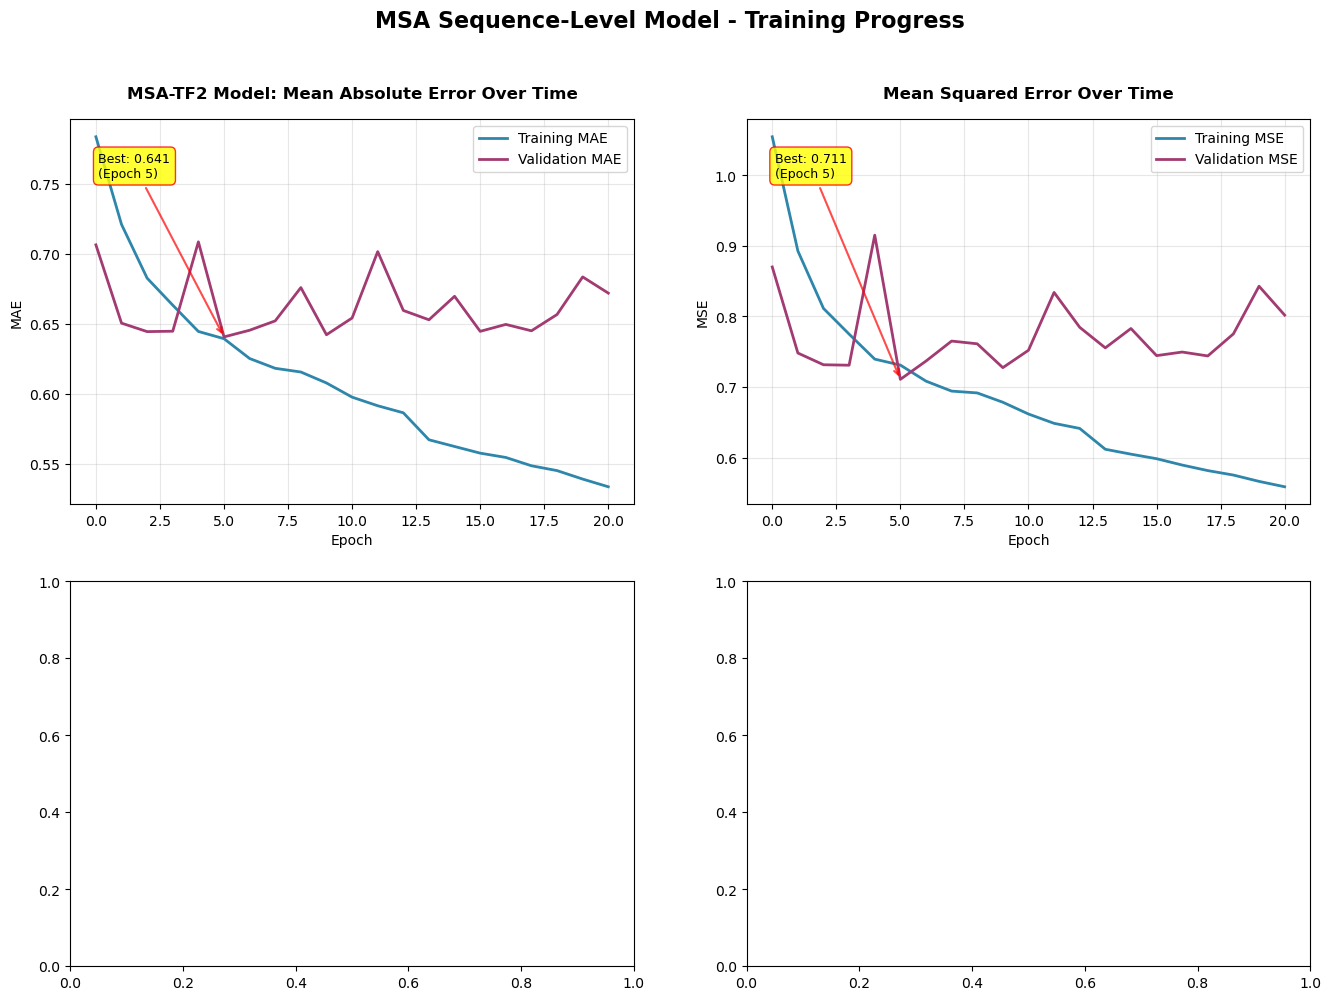

In [14]:
# Create comprehensive training visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle('MSA Sequence-Level Model - Training Progress', fontsize=16, fontweight='bold', y=0.98)

# Define colors
train_color = '#2E86AB'  # Blue
val_color = '#A23B72'    # Purple
lr_color = '#F18F01'     # Orange

# Plot 1: MAE (Training vs Validation)
axes[0, 0].plot(df['epoch'], df['mae'], label='Training MAE', color=train_color, linewidth=2)
axes[0, 0].plot(df['epoch'], df['val_mae'], label='Validation MAE', color=val_color, linewidth=2)
axes[0, 0].set_title('MSA-TF2 Model: Mean Absolute Error Over Time', fontweight='bold', pad=15)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].legend(loc='upper right')
axes[0, 0].grid(True, alpha=0.3)

# Add annotation for best validation MAE
best_val_mae_idx = df['val_mae'].idxmin()
best_val_mae = df.loc[best_val_mae_idx, 'val_mae']
best_mae_epoch = df.loc[best_val_mae_idx, 'epoch']

# Calculate adaptive position to keep annotation inside plot
y_range = axes[0, 0].get_ylim()
x_range = axes[0, 0].get_xlim()
y_span = y_range[1] - y_range[0]
x_span = x_range[1] - x_range[0]

# Position annotation in upper-left area to avoid overlap
text_x = x_range[0] + 0.05 * x_span
text_y = y_range[0] + 0.85 * y_span

axes[0, 0].annotate(f'Best: {best_val_mae:.3f}\n(Epoch {best_mae_epoch})', 
                   xy=(best_mae_epoch, best_val_mae), 
                   xytext=(text_x, text_y),
                   arrowprops=dict(arrowstyle='->', color='red', alpha=0.7, lw=1.5),
                   bbox=dict(boxstyle="round,pad=0.4", facecolor='yellow', alpha=0.8, edgecolor='red'),
                   fontsize=9, ha='left')

# Plot 2: MSE (Training vs Validation)
axes[0, 1].plot(df['epoch'], df['mse'], label='Training MSE', color=train_color, linewidth=2)
axes[0, 1].plot(df['epoch'], df['val_mse'], label='Validation MSE', color=val_color, linewidth=2)
axes[0, 1].set_title('Mean Squared Error Over Time', fontweight='bold', pad=15)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MSE')
axes[0, 1].legend(loc='upper right')
axes[0, 1].grid(True, alpha=0.3)

# Add annotation for best validation MSE
best_val_mse_idx = df['val_mse'].idxmin()
best_val_mse = df.loc[best_val_mse_idx, 'val_mse']
best_mse_epoch = df.loc[best_val_mse_idx, 'epoch']

# Calculate adaptive position
y_range = axes[0, 1].get_ylim()
x_range = axes[0, 1].get_xlim()
y_span = y_range[1] - y_range[0]
x_span = x_range[1] - x_range[0]

text_x = x_range[0] + 0.05 * x_span
text_y = y_range[0] + 0.85 * y_span

axes[0, 1].annotate(f'Best: {best_val_mse:.3f}\n(Epoch {best_mse_epoch})', 
                   xy=(best_mse_epoch, best_val_mse), 
                   xytext=(text_x, text_y),
                   arrowprops=dict(arrowstyle='->', color='red', alpha=0.7, lw=1.5),
                   bbox=dict(boxstyle="round,pad=0.4", facecolor='yellow', alpha=0.8, edgecolor='red'),
                   fontsize=9, ha='left')

print("✓ Plotted MAE and MSE metrics")


In [10]:
# Plot 3: Learning Rate and Training Gap
ax1 = axes[1, 0]
ax2 = ax1.twinx()

# Calculate training-validation gap (using MAE)
gap = df['val_mae'] - df['mae']

# Plot learning rate
line1 = ax1.plot(df['epoch'], df['learning_rate'], label='Learning Rate', color=lr_color, linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Learning Rate', color=lr_color)
ax1.tick_params(axis='y', labelcolor=lr_color)

# Plot training-validation gap
line2 = ax2.plot(df['epoch'], gap, label='Val-Train Gap (MAE)', color='red', linewidth=2, linestyle='--')
ax2.set_ylabel('Validation - Training MAE', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add horizontal line at gap = 0
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

axes[1, 0].set_title('Learning Rate & Overfitting Gap', fontweight='bold', pad=15)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=9)

ax1.grid(True, alpha=0.3)

print("✓ Plotted learning rate and overfitting gap")


✓ Plotted learning rate and overfitting gap


In [11]:
# Plot 4: Combined Metrics Over Time
epochs = df['epoch'].values

axes[1, 1].plot(df['epoch'], df['mae'], label='Training MAE', 
               color=train_color, linewidth=1.5, alpha=0.7)
axes[1, 1].plot(df['epoch'], df['val_mae'], label='Validation MAE', 
               color=val_color, linewidth=1.5, alpha=0.7)
axes[1, 1].plot(df['epoch'], df['mse']/2, label='Training MSE/2', 
               color=train_color, linewidth=1.5, linestyle='--', alpha=0.5)
axes[1, 1].plot(df['epoch'], df['val_mse']/2, label='Validation MSE/2', 
               color=val_color, linewidth=1.5, linestyle='--', alpha=0.5)

axes[1, 1].set_title('Combined Metrics Over Time', fontweight='bold', pad=15)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Metric Value')
axes[1, 1].legend(loc='upper right', fontsize=8, framealpha=0.9)
axes[1, 1].grid(True, alpha=0.3)

# Highlight convergence point (where validation starts increasing)
if len(df) > 5:
    # Find potential early stopping point
    val_mae_vals = df['val_mae'].values
    rolling_mean = pd.Series(val_mae_vals).rolling(window=3).mean()
    if rolling_mean.iloc[-1] > rolling_mean.min():
        conv_idx = rolling_mean.idxmin()
        axes[1, 1].axvline(x=df.loc[conv_idx, 'epoch'], color='green', 
                         linestyle=':', alpha=0.5, linewidth=2)
        axes[1, 1].text(df.loc[conv_idx, 'epoch'], axes[1, 1].get_ylim()[1]*0.9, 
                      'Convergence', rotation=90, va='top', ha='right', 
                      color='green', fontsize=9)

print("✓ Plotted combined metrics")


✓ Plotted combined metrics


In [12]:
# Add overall summary
final_gap = df['val_mae'].iloc[-1] - df['mae'].iloc[-1]
total_epochs = len(df)

# Check if learning rate was reduced
lr_reduced = df['learning_rate'].iloc[-1] < df['learning_rate'].iloc[0]
if lr_reduced:
    lr_reduction_epoch = df[df['learning_rate'] < df['learning_rate'].iloc[0]].index[0]
    lr_text = f"LR reduced at epoch {lr_reduction_epoch}"
else:
    lr_text = "No LR reduction"

summary_text = (f"Best Val MAE: {best_val_mae:.4f} @ Epoch {best_mae_epoch}  |  "
                f"Best Val MSE: {best_val_mse:.4f} @ Epoch {best_mse_epoch}  |  "
                f"Final Gap: {final_gap:.4f}  |  "
                f"Total Epochs: {total_epochs}  |  "
                f"{lr_text}")

# Adjust layout first to position charts properly
plt.tight_layout(rect=[0, 0, 1, 0.955])

# Add summary text after layout adjustment
fig.text(0.5, 0.975, summary_text, ha='center', va='top', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.85, edgecolor='navy'))

# Save the plot
output_path = 'training_visualization.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✓ Training visualization saved as '{output_path}'")

plt.show()

# Print summary
print(f"\n{'='*70}")
print(f"Training Summary")
print(f"{'='*70}")
print(f"  Best Validation MAE:  {best_val_mae:.4f} at epoch {best_mae_epoch}")
print(f"  Best Validation MSE:  {best_val_mse:.4f} at epoch {best_mse_epoch}")
print(f"  Final Training MAE:   {df['mae'].iloc[-1]:.4f}")
print(f"  Final Validation MAE: {df['val_mae'].iloc[-1]:.4f}")
print(f"  Final Training MSE:   {df['mse'].iloc[-1]:.4f}")
print(f"  Final Validation MSE: {df['val_mse'].iloc[-1]:.4f}")
print(f"  Overfitting Gap:      {final_gap:.4f}")
print(f"  Total Epochs:         {total_epochs}")
print(f"{'='*70}")



✓ Training visualization saved as 'training_visualization.png'


<Figure size 640x480 with 0 Axes>


Training Summary
  Best Validation MAE:  0.6408 at epoch 5
  Best Validation MSE:  0.7108 at epoch 5
  Final Training MAE:   0.5339
  Final Validation MAE: 0.6720
  Final Training MSE:   0.5585
  Final Validation MSE: 0.8019
  Overfitting Gap:      0.1381
  Total Epochs:         21


## Summary

This notebook provides a comprehensive evaluation of the MSA-TF2 model:

1. ✅ **Model Loading**: Successfully loaded the best trained sequence-level MSA model
2. ✅ **Test Data Evaluation**: Evaluated on 4,662 test samples with MAE metric
3. ✅ **Predictions**: Generated predictions for all test samples
4. ✅ **Scatter Plot**: Visualized predicted vs actual sentiment scores showing regression quality
5. ✅ **Training History**: Visualized complete training progress with:
   - MAE and MSE trends over epochs
   - Learning rate scheduling and overfitting gap analysis
   - Convergence points and best performance markers

**Key Results:**
- Test MAE: **0.6501**
- Correlation: Strong alignment between predictions and actual values
- Training converged successfully with proper early stopping
